In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from custom_datasets import SkinLesionDataset
from pathlib import Path
from tqdm import tqdm

df = pd.read_csv('../data/train-metadata.csv')

df_malignant = df[df['target'] == 1]
df_benign = df[df['target'] == 0]

print(f"Total Malignant: {len(df_malignant)}")
print(f"Total Benign: {len(df_benign)}")

test_mal, train_val_mal = train_test_split(df_malignant, test_size=None, train_size=50)
test_ben, train_val_ben = train_test_split(df_benign, test_size=None, train_size=1000)

val_mal, train_mal = train_test_split(train_val_mal, test_size=None, train_size=50)
val_ben, train_ben = train_test_split(train_val_ben, test_size=None, train_size=1000)

# 5. Create Training Set (The Balancing Act)
# We now have ~300 Malignant images left.
# We have ~398,000 Benign images left.
# WE CANNOT USE ALL BENIGN IMAGES. It will drown out the signal.

# Downsample Benign to a 1:5 ratio (300 Malignant : 1500 Benign)
# This gives the model a chance to actually see the cancer.
train_ben_downsampled = train_ben.sample(n=1500)

# Concatenate back together
train_df = pd.concat([train_mal, train_ben_downsampled])
val_df = pd.concat([val_mal, val_ben])
test_df = pd.concat([test_mal, test_ben])

# Shuffle them
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

print(f"Training Set: {len(train_df)} images ({train_df['target'].sum()} Malignant)")
print(f"Val Set: {len(val_df)} images ({val_df['target'].sum()} Malignant)")
print(f"Test Set: {len(test_df)} images ({test_df['target'].sum()} Malignant)")

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    # other augmentations for train dataset
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean and std
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_ds = SkinLesionDataset(dataframe=train_df,
                             root_dir=Path('../data/train-image/image'),
                             transforms=train_transforms)
val_ds = SkinLesionDataset(dataframe=val_df,
                           root_dir=Path('../data/train-image/image'),
                           transforms=val_transforms)
test_ds = SkinLesionDataset(dataframe=test_df,
                            root_dir=Path('../data/train-image/image'),
                            transforms=test_transforms)

train_loader = DataLoader(train_ds, batch_size=32)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=32, 
                               kernel_size=3, 
                               padding=1) # 32, 128, 128
        self.batchNorm1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU(inplace=True) # inplace saves gpu memory (vram), modifies input tensor directly in memory rather than creating a new tensor for the output
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 32, 64, 64

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(32 * 64 * 64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        return self.fc(x)
    
print('cuda available:', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
# maybe add pos_weight to tell model to pay more attention to malignant cases
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images) 
        
        loss = criterion(outputs, labels.view(-1, 1).float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = torch.sigmoid(outputs) > 0.5
        total += labels.size(0)
        correct += (predicted.view(-1) == labels).sum().item()
        
    avg_loss = running_loss / len(loader)
    acc = 100 * correct / total
    return avg_loss, acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1, 1).float())
            
            running_loss += loss.item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted.view(-1) == labels).sum().item()
            
    avg_loss = running_loss / len(loader)
    acc = 100 * correct / total
    return avg_loss, acc

EPOCHS = 10

print("Starting Training...")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print("-" * 30)

C:\Users\User\AppData\Local\Temp\ipykernel_19784\2974898551.py:12: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/train-metadata.csv')


Total Malignant: 393
Total Benign: 400666
Training Set: 1793 images (293 Malignant)
Val Set: 1050 images (50 Malignant)
Test Set: 1050 images (50 Malignant)
cuda available: True
Starting Training...


100%|██████████| 33/33 [00:08<00:00,  4.12it/s]


Epoch [1/10]
Train Loss: 3.4640 | Train Acc: 78.47%
Val Loss:   0.4469 | Val Acc:   93.24%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 25.15it/s]


Epoch [2/10]
Train Loss: 0.5358 | Train Acc: 83.88%
Val Loss:   0.2575 | Val Acc:   92.00%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 27.23it/s]


Epoch [3/10]
Train Loss: 0.6388 | Train Acc: 83.99%
Val Loss:   0.6684 | Val Acc:   77.62%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 26.79it/s]


Epoch [4/10]
Train Loss: 0.3809 | Train Acc: 86.89%
Val Loss:   0.3101 | Val Acc:   89.24%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 21.91it/s]


Epoch [5/10]
Train Loss: 0.3413 | Train Acc: 88.01%
Val Loss:   0.3528 | Val Acc:   88.76%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 27.30it/s]


Epoch [6/10]
Train Loss: 0.2695 | Train Acc: 90.41%
Val Loss:   0.6430 | Val Acc:   76.76%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 28.21it/s]


Epoch [7/10]
Train Loss: 0.2549 | Train Acc: 90.41%
Val Loss:   0.5028 | Val Acc:   81.43%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 26.29it/s]


Epoch [8/10]
Train Loss: 0.2418 | Train Acc: 91.69%
Val Loss:   0.3529 | Val Acc:   89.33%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 26.57it/s]


Epoch [9/10]
Train Loss: 0.2083 | Train Acc: 93.14%
Val Loss:   0.3057 | Val Acc:   92.38%
------------------------------


100%|██████████| 33/33 [00:01<00:00, 25.27it/s]

Epoch [10/10]
Train Loss: 0.1592 | Train Acc: 94.59%
Val Loss:   0.3978 | Val Acc:   90.10%
------------------------------


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

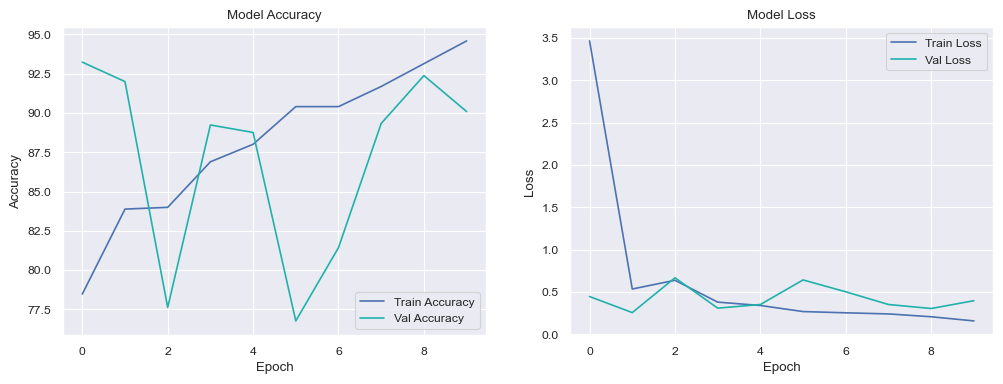

In [21]:
sns.set_theme('paper')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=history['train_acc'], label='Train Accuracy', ax=ax[0])
sns.lineplot(data=history['val_acc'], label='Val Accuracy', ax=ax[0], c='lightseagreen')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')

sns.lineplot(data=history['train_loss'], label='Train Loss', ax=ax[1])
sns.lineplot(data=history['val_loss'], label='Val Loss', ax=ax[1], c='lightseagreen')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.savefig('acc_loss.jpg')

In [22]:
test_loss, test_acc = validate(model, test_loader, criterion, device)

100%|██████████| 33/33 [00:07<00:00,  4.25it/s]


In [23]:
print(f"Test Loss: {train_loss:.4f}")
print(f"Test Acc: {test_acc:.2f}%")

Test Loss: 0.1592
Test Acc: 91.33%


In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrices(model, device, train_loader, val_loader, test_loader):
    model.eval()
    loaders = {'Train': train_loader, 'Validation': val_loader, 'Test': test_loader}
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    with torch.no_grad():
        for ax, (name, loader) in zip(axes, loaders.items()):
            all_targets = []
            all_preds = []
            
            for images, labels in tqdm(loader):
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                preds = (torch.sigmoid(outputs) > 0.5).float().view(-1)
                
                all_targets.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
            
            # [[TN, FP], [FN, TP]]
            cm = confusion_matrix(all_targets, all_preds)
            
            group_names = ['TN','FP','FN','TP']
            group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
            group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
            
            labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in 
                      zip(group_names, group_counts, group_percentages)]
            labels = np.asarray(labels).reshape(2,2)
            
            sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax, cbar=False,
                        xticklabels=['Benign (0)', 'Malignant (1)'],
                        yticklabels=['Benign (0)', 'Malignant (1)'])
            
            ax.set_title(f'{name} Dataset')
            ax.set_ylabel('Actual Label')
            ax.set_xlabel('Predicted Label')
            plt.savefig('confusion_matrix.jpg')

    plt.tight_layout()
    plt.show()

100%|██████████| 33/33 [00:01<00:00, 23.02it/s]


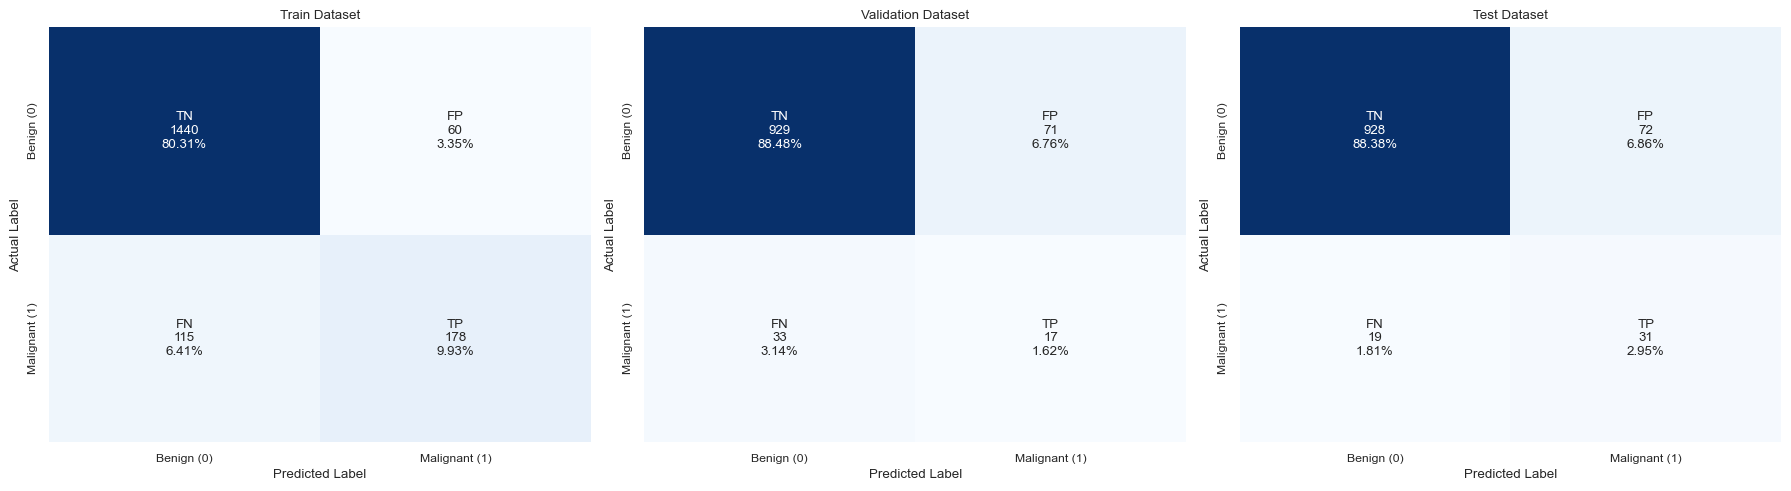

In [25]:
plot_confusion_matrices(model, device, train_loader, val_loader, test_loader)